In [1]:
from osier import *
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import normalize
from pymoo.core.problem import Problem
from pymoo.core.problem import ElementwiseProblem
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.algorithms.moo.unsga3 import UNSGA3
from pymoo.termination import get_termination
from pymoo.optimize import minimize
from pymoo.termination.ftol import MultiObjectiveSpaceTermination
from pymoo.visualization.scatter import Scatter
from pymoo.operators.sampling.rnd import FloatRandomSampling
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PolynomialMutation
from pymoo.termination.robust import RobustTermination
from pymoo.core.parameters import set_params, hierarchical

from pygenesys.utils.tsprocess import aggregate

from copy import deepcopy
import time
import dill

# Import solar, wind, demand

In [2]:
n_hours = 24
n_days = 2
N = n_hours*n_days
scale = 1
total_demand = 187e3 * n_days/365 * scale
# phase_shift = 0
# base_shift = 1.5
# total_demand = 185
# hours = np.linspace(0,N,N)
# demand = (np.sin((hours*np.pi/n_hours*2+phase_shift))*-1+np.ones(N)*(base_shift+1))

In [3]:
total_demand

1024.6575342465753

In [6]:
wdf = pd.read_csv('../../../2021-dotson-ms/data/railsplitter_data.csv', 
                  usecols=['time', 'kw'], 
                  index_col='time', 
                  parse_dates=True)
# wdf = wdf[wdf.index.year == 2017][:N]/scale
sdf = pd.read_csv('../../../2021-dotson-ms/data/solarfarm_data.csv', 
                  usecols=['time', 'kw'],
                  index_col='time', 
                  parse_dates=True)
# sdf = sdf[sdf.index.year == 2017][:N]/scale
ddf = pd.read_csv('../../../2021-dotson-ms/data/uiuc_demand_data.csv',
                  usecols=['time', 'kw'],
                  index_col='time',
                  parse_dates=True)
# ddf = ddf[ddf.index.year == 2017][:N]/scale

In [7]:
ddf = aggregate(ddf,
                N_seasons=365,
                N_hours=n_hours,
                kind='demand',
                groupby='day')
sdf = aggregate(sdf,
                N_seasons=365,
                N_hours=n_hours,
                kind='cf',
                groupby='day')
wdf = aggregate(wdf,
                N_seasons=365,
                N_hours=n_hours,
                kind='cf',
                groupby='day')

In [8]:
ddf = ddf.flatten()[:N]
ddf = ddf/ddf.sum() * total_demand
sdf = sdf.flatten()[:N]
wdf = wdf.flatten()[:N]

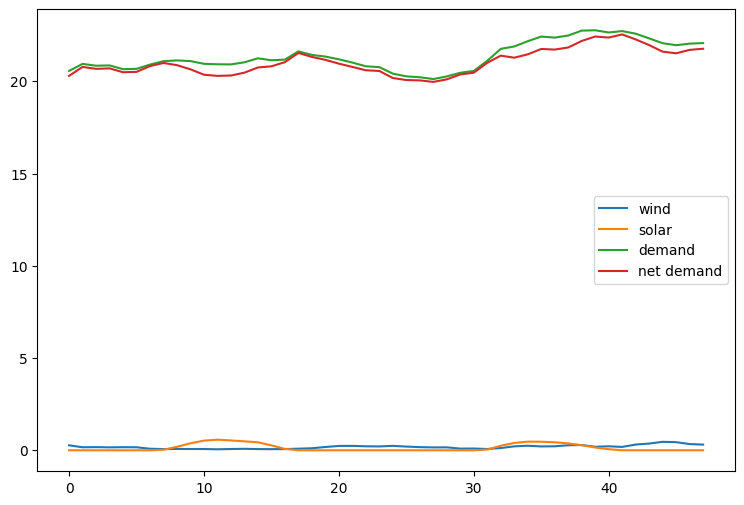

In [9]:
fig, ax = plt.subplots(facecolor='w', figsize=(9,6))
ax.plot(wdf, label='wind')
ax.plot(sdf, label='solar')
ax.plot(ddf, label='demand')
ax.plot(ddf-sdf-wdf, label='net demand')
plt.legend()
plt.show()

In [10]:
ddf.max()

22.763087361657945

# Create Technologies

In [11]:
from unyt import GW, hour
nuclear = ThermalTechnology(technology_name='Nuclear',
                     capacity=18.609404*scale,
                     capital_cost=0.05*1e3*scale,
                     om_cost_variable=0.0,
                     om_cost_fixed=0.17773741*1e3*scale,
                     fuel_cost=0.005811*scale,
                     ramp_up_rate=0.0,
                     ramp_down_rate=0.0,
                     )
nuclear_adv = ThermalTechnology(technology_name='Nuclear_Adv',
                     capacity=0*scale,
                     capital_cost=4.9164*1e3*scale,
                     om_cost_variable=0.0,
                     om_cost_fixed=0.11899*1e3*scale,
                     fuel_cost=0.009158*scale,
                     ramp_up_rate=0.25,
                     ramp_down_rate=0.25,
                     )
natural_gas = ThermalTechnology(technology_name='NaturalGas_Conv',
                         capacity=8.3751331*scale,
                         capital_cost=0.95958*1e3*scale,
                         om_cost_variable=0.0,
                         om_cost_fixed=0.0111934*1e3*scale,
                         fuel_cost=0.022387*scale,
                         ramp_up_rate=1.0,
                         ramp_down_rate=1.0,
                         )
biomass = ThermalTechnology(technology_name='Biomass',
                         capacity=0*scale,
                         capital_cost=3.436*1e3*scale,
                         om_cost_variable=0.0,
                         om_cost_fixed=0.123*1e3*scale,
                         fuel_cost=0.047*scale,
                         ramp_up_rate=1.0,
                         ramp_down_rate=1.0,
                         )
natural_gas_adv = ThermalTechnology(technology_name='NaturalGas_Adv',
                         capacity=0*scale,
                         capital_cost=1.8910*1e3*scale,
                         om_cost_variable=0.0,
                         om_cost_fixed=0.02699*1e3*scale,
                         fuel_cost=0.027475*scale,
                         ramp_up_rate=1.0,
                         ramp_down_rate=1.0,
                         )
coal = ThermalTechnology(technology_name='Coal_Conv',
                         capacity=0*scale,
                         capital_cost=1.00*1e3*scale,
                         om_cost_variable=0.0,
                         om_cost_fixed=0.0407033*1e3*scale,
                         fuel_cost=0.021369*scale,
                         ramp_up_rate=0.5,
                         ramp_down_rate=0.5,
                         )
coal_adv = ThermalTechnology(technology_name='Coal_Adv',
                         capacity=0*scale,
                         capital_cost=4.9246*1e3*scale,
                         om_cost_variable=0.0,
                         om_cost_fixed=0.05824*1e3*scale,
                         fuel_cost=0.0366329*scale,
                         ramp_up_rate=0.5,
                         ramp_down_rate=0.5,
                         )
battery = StorageTechnology(technology_name='Battery',
                         capacity=0.81534126*scale,
                         capital_cost=0.613*1e3*scale,
                         om_cost_variable=0,
                         om_cost_fixed=0.01532*1e3*scale,
                         fuel_cost=0,
                         storage_duration=4,
                         efficiency=0.85,
                         initial_storage=0,
                         )
wind = Technology(technology_name='WindTurbine',
                  renewable=True,
                  dispatchable=False,
                  fuel_type='wind',
                  capacity=0*scale, 
                  capital_cost=1.1806*1e3*scale,
                  om_cost_fixed=0.03311*1e3*scale)
solar = Technology(technology_name='SolarPanel',
                  renewable=True,
                  dispatchable=False,
                  fuel_type='solar',
                  capacity=2.8103015*scale, 
                  capital_cost=0.6732*1e3*scale,
                  om_cost_fixed=0.00805*1e3*scale)

# Add CO2 Data

In [13]:
nuclear.co2 = 1.2e-5 * scale
nuclear_adv.co2 = nuclear.co2
solar.co2 = 4.8e-5 * scale
wind.co2 = 1.1e-5 * scale
natural_gas.co2 = 4.90e-4 * scale
natural_gas_adv.co2 = 4.9e-5 * scale
coal.co2 = 8.20e-4 * scale
coal_adv.co2 = 2.20e-4 * scale
biomass.co2 = 2.30e-4 * scale
battery.co2 = 2.32e-5 * scale

# Add capacity credit

In [14]:
nuclear.cap_credit = 1.0
nuclear_adv.cap_credit = 1.0 
solar.cap_credit = 0.188
wind.cap_credit = 0.35
natural_gas.cap_credit = 1.0
natural_gas_adv.cap_credit = 1.0
coal.cap_credit = 1.0
coal_adv.cap_credit = 1.0
biomass.cap_credit = 1.0
battery.cap_credit = 0.5

In [15]:
techs = [nuclear, 
         nuclear_adv,
         natural_gas,
         natural_gas_adv,
         coal,
         coal_adv,
         biomass,
         battery,
         solar,
         wind
         ]

X_init = np.array([[t.capacity.to_value() for t in techs]])


# Run Genetic Algorithm

In [16]:
from osier.models.capacity_expansion import CapacityExpansion
problem = CapacityExpansion(technology_list=techs,
                            objectives=[total_cost, annual_co2],
                            demand=ddf,
                            solar=sdf,
                            wind=wdf)

# Repair Operator

In [17]:
from pymoo.core.repair import Repair

class PortfolioRepair(Repair):

    def _do(self, problem, X, **kwargs):
        # zero out small numbers
        # make sure the portfolio equals one
        X = X/X.sum(axis=1, keepdims=True)
        X[X<1e-2] = 0
        X = X/X.sum(axis=1, keepdims=True)
#         I = np.eye(problem.n_var, problem.n_var) * problem.capacity_credit
#         X = ((X.T)/(I@X.T).sum(axis=0, keepdims=True)).T      
        return X

In [18]:
with open('../2022-11-14-optimal_hyperparams.pkl', 'rb') as file:
    hyperparams = dill.load(file)

In [19]:
display(hyperparams)

{'mating.mutation.eta': 3.0030881200683117,
 'mating.mutation.prob': 0.8036682181129143,
 'mating.crossover.prob_bin': 0.20445224973151743,
 'mating.crossover.prob_exch': 0.5586898284457517,
 'mating.crossover.eta': 11.397451820343866,
 'mating.crossover.prob_var': 0.1303515134021974,
 'mating.crossover.prob': 0.978944765075251}

# UNSGA3 & Reference Directions

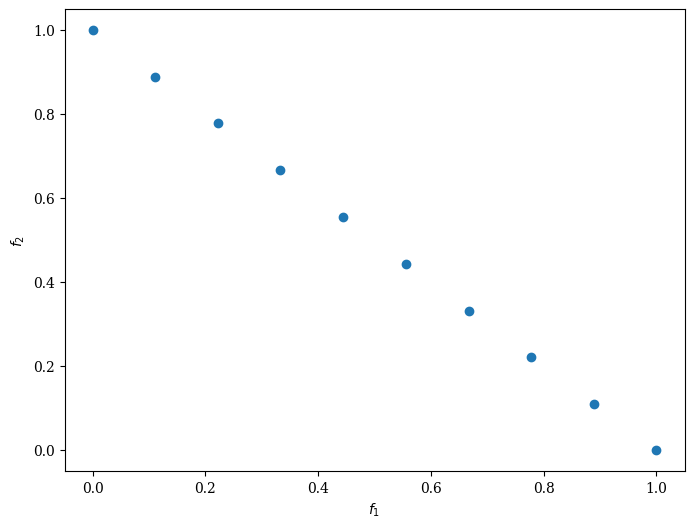

In [36]:
from pymoo.util.ref_dirs import get_reference_directions
from pymoo.visualization.scatter import Scatter

ref_dirs = get_reference_directions("energy", 2, 10, seed=1)
Scatter().add(ref_dirs).show()

In [21]:
algorithm = UNSGA3(
    ref_dirs=ref_dirs,
    pop_size=10,
    n_offsprings=10,
    sampling=FloatRandomSampling(),
#     sampling=np.eye(10),
    crossover=SBX(prob=0.9, eta=15),
    mutation=PolynomialMutation(eta=50),
    eliminate_duplicates=True,
    repair = PortfolioRepair()
)
set_params(algorithm, hierarchical(hyperparams))
# termination = RobustTermination(
#     MultiObjectiveSpaceTermination(tol=1, n_skip=5), period=5)
termination = get_termination("n_gen", 5)

In [22]:
start = time.perf_counter()
res = minimize(problem,
               algorithm,
               termination,
               pf=False,
               seed=5,
               save_history=True,
               verbose=True)
end = time.perf_counter()

n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |       10 |      4 |             - |             -
     2 |       20 |      3 |  0.1933116311 |         ideal
     3 |       30 |      3 |  0.0475437656 |         ideal
     4 |       40 |      4 |  0.1806239166 |         ideal
     5 |       50 |      4 |  0.0226319534 |         ideal


In [23]:
F = res.F
X = res.X

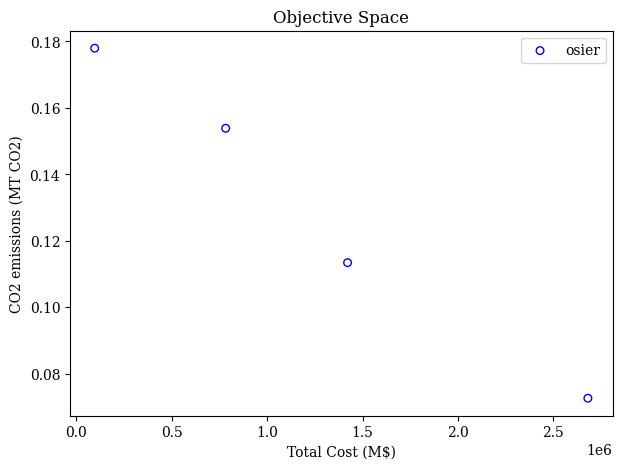

In [24]:
plt.figure(figsize=(7, 5), facecolor='w')
plt.scatter(F[:, 0], F[:, 1], s=30, facecolors='none', edgecolors='blue', label='osier')
plt.title("Objective Space")
plt.xlabel("Total Cost (M$)")
plt.ylabel("CO2 emissions (MT CO2)")
plt.legend()
plt.show()

In [25]:
res.exec_time

189.77547097206116

# Hyperparameter Tuning

In [26]:
from pymoo.core.parameters import get_params, flatten, set_params, hierarchical
a = UNSGA3(ref_dirs)
flatten(get_params(a))

{'mating.mutation.eta': <pymoo.core.variable.Real at 0x7f79ee461660>,
 'mating.mutation.prob': <pymoo.core.variable.Real at 0x7f79ee461630>,
 'mating.crossover.prob_bin': <pymoo.core.variable.Real at 0x7f79ee461570>,
 'mating.crossover.prob_exch': <pymoo.core.variable.Real at 0x7f79ee461510>,
 'mating.crossover.eta': <pymoo.core.variable.Real at 0x7f79ee4614e0>,
 'mating.crossover.prob_var': <pymoo.core.variable.Real at 0x7f79ee461450>,
 'mating.crossover.prob': <pymoo.core.variable.Real at 0x7f79ee461420>}

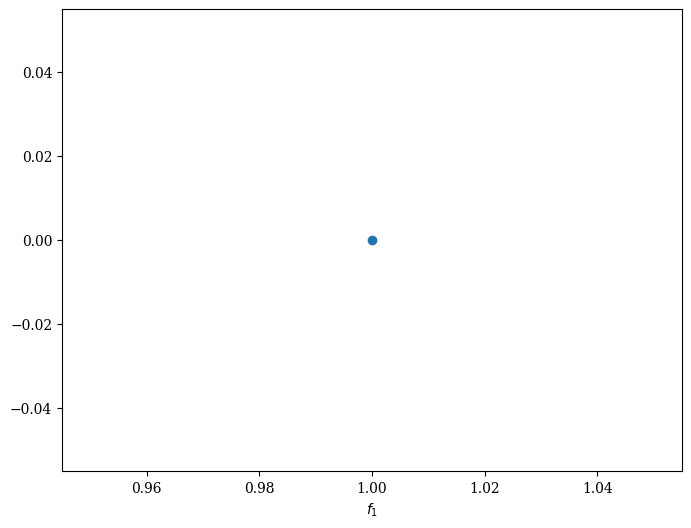

In [37]:
ref_dirs = get_reference_directions("energy", 1, 100, seed=1)
Scatter().add(ref_dirs).show()

In [46]:
from pymoo.algorithms.hyperparameters import HyperparameterProblem, MultiRun, stats_single_objective_mean
from pymoo.algorithms.soo.nonconvex.g3pcx import G3PCX
from pymoo.core.mixed import MixedVariableGA
from pymoo.core.parameters import set_params, hierarchical
from pymoo.optimize import minimize
from pymoo.problems.single import Sphere
from pymoo.core.termination import TerminateIfAny
from pymoo.termination.fmin import MinimumFunctionValueTermination
from pymoo.termination.max_eval import MaximumFunctionCallTermination

algorithm = UNSGA3(
    ref_dirs=ref_dirs,
    repair = PortfolioRepair()
)
print("Problem and algorithm initialized ...")
problem = CapacityExpansion(technology_list=techs,
                       objectives=[total_cost],
                       demand=ddf,
                       solar=sdf,
                       wind=wdf)
n_evals = 500
min_val = 3700
seeds = [5, 50, 500]
termination = TerminateIfAny(MinimumFunctionValueTermination(min_val), MaximumFunctionCallTermination(n_evals))
performance = MultiRun(problem, 
                       seeds=seeds, 
                       func_stats=stats_single_objective_mean,
                       termination=termination)

print("Starting hyperparameter optimization...")
start = time.perf_counter()

res = minimize(HyperparameterProblem(algorithm, performance),
               MixedVariableGA(pop_size=5),
               termination=('n_evals', 50),
               seed=1,
               verbose=True)
end = time.perf_counter()
print(f"Hyperparameter optimization took {end-start} seconds or {((end-start)/3600)} hours.")
hyperparams = res.X
print(hyperparams)

print("Saving hyperparameters")
with open('../2022-12-10-optimal_hyperparams_UNSGA3.pkl', 'wb') as file:
    dill.dump(hyperparams, file)


print("Updating reference directions")    
ref_dirs = get_reference_directions("energy", 2, 100, seed=1)

algorithm = UNSGA3(
    ref_dirs=ref_dirs,
    repair = PortfolioRepair()
)
print("Setting optimal hyperparameters")
set_params(algorithm, hierarchical(hyperparams))

termination = RobustTermination(
    MultiObjectiveSpaceTermination(tol=1e-2, n_skip=5), period=20)

print("Minimization with optimal hyperparams...")
problem = CapacityExpansion(technology_list=techs,
                            objectives=[total_cost, annual_co2],
                            demand=ddf,
                            solar=sdf,
                            wind=wdf)
res = minimize(problem, algorithm, termination=termination, seed=5)
print("Best solution found: \nX = %s\nF = %s" % (res.X, res.F))
print(f"Final optimization took: {res.exec_time/3600} hours.")

Problem and algorithm initialized ...
Starting hyperparameter optimization...
n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |        5 |  3.515191E+03 |  3.464711E+03
     2 |       10 |  3.415280E+03 |  3.321668E+03
     3 |       15 |  3.383878E+03 |  3.321668E+03
     4 |       20 |  3.338440E+03 |  3.321668E+03
     5 |       25 |  3.328295E+03 |  3.321668E+03
     6 |       30 |  3.313041E+03 |  3.261282E+03
     7 |       35 |  3.290626E+03 |  3.261282E+03
     8 |       40 |  3.269562E+03 |  3.261282E+03
     9 |       45 |  3.265535E+03 |  3.261282E+03
    10 |       50 |  3.261320E+03 |  3.261282E+03
Hyperparameter optimization took 28075.955369893 seconds or 7.798876491636944 hours.
{'mating.mutation.eta': 14.130178796688453, 'mating.mutation.prob': 0.735971441676471, 'mating.crossover.prob_bin': 0.006784902715194836, 'mating.crossover.prob_exch': 0.7407147138663094, 'mating.crossover.eta': 23.965948337505676, 'mating.crossover.prob_var': 0.7148003814714371, 'matin

In [47]:
F = res.F
X = res.X
display(X,F)

array([[0.        , 0.        , 0.01709129, 0.96762574, 0.        ,
        0.        , 0.        , 0.01528297, 0.        , 0.        ],
       [0.        , 0.        , 0.07527342, 0.90898414, 0.        ,
        0.        , 0.        , 0.01574244, 0.        , 0.        ],
       [0.        , 0.        , 0.27502883, 0.71381064, 0.        ,
        0.        , 0.        , 0.01116053, 0.        , 0.        ],
       [0.46022026, 0.        , 0.        , 0.53977974, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.17768221, 0.80606743, 0.        ,
        0.        , 0.        , 0.01625036, 0.        , 0.        ],
       [0.72278669, 0.        , 0.        , 0.26488004, 0.        ,
        0.        , 0.        , 0.01233327, 0.        , 0.        ],
       [0.10205576, 0.        , 0.        , 0.88300088, 0.        ,
        0.        , 0.        , 0.01494335, 0.        , 0.        ],
       [0.        , 0.        , 0.8722993

array([[2.32174908e+03, 5.84774447e-02],
       [2.25050474e+03, 8.65141683e-02],
       [2.01470657e+03, 1.82751709e-01],
       [3.16121424e+03, 3.16027827e-02],
       [2.12553456e+03, 1.35861647e-01],
       [3.59822875e+03, 2.10122088e-02],
       [2.51968278e+03, 4.61149447e-02],
       [1.28408917e+03, 4.70558887e-01],
       [1.88650308e+03, 2.32819062e-01],
       [2.15528439e+03, 1.23955301e-01],
       [1.94990533e+03, 2.05948804e-01],
       [2.93689955e+03, 3.68400088e-02],
       [2.23566605e+03, 9.29601637e-02],
       [1.45001001e+03, 4.04590667e-01],
       [1.70451890e+03, 3.05005937e-01],
       [1.57604239e+03, 3.54393065e-01],
       [2.18501157e+03, 1.13467579e-01],
       [1.38404923e+03, 4.31146160e-01],
       [2.82887179e+03, 3.88709335e-02],
       [2.21748806e+03, 9.96448562e-02],
       [1.43179347e+03, 4.12322150e-01],
       [1.25738182e+03, 4.81308115e-01],
       [3.42884941e+03, 2.50092128e-02],
       [1.36892885e+03, 4.37657183e-01],
       [2.590805

import dill
with open("2023-dotson-prelim/data/2022-11-16-optimal_hyperparams.pkl", "wb") as hp:
    dill.dump(hyperparams, hp)
with open("2023-dotson-prelim/data/2022-11-16-optimal_objective_F.pkl", "wb") as obj_F:
    dill.dump(F, obj_F)
with open("2023-dotson-prelim/data/2022-11-16-optimal_design_X.pkl", "wb") as des_X:
    dill.dump(X, des_X)
with open("2023-dotson-prelim/data/2022-11-16-techset.pkl", "wb") as ts:
    dill.dump(techs, ts)

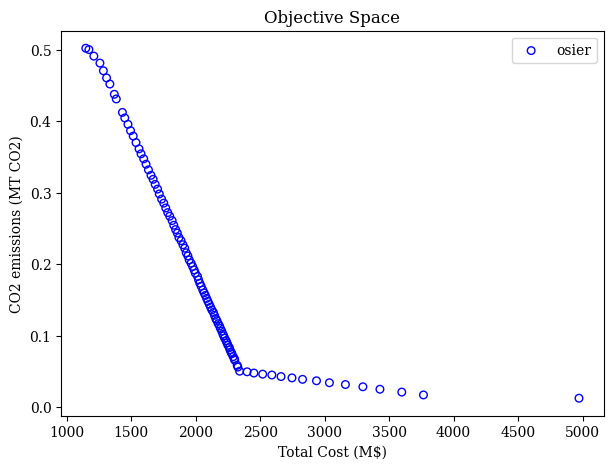

In [48]:
plt.figure(figsize=(7, 5), facecolor='w')
plt.scatter(F[:, 0], F[:, 1], s=30, facecolors='none', edgecolors='blue', label='osier')
plt.title("Objective Space")
plt.xlabel("Total Cost (M$)")
plt.ylabel("CO2 emissions (MT CO2)")
plt.legend()
plt.show()

In [69]:
hyperparams

{'mating.mutation.eta': 3.0030881200683117,
 'mating.mutation.prob': 0.8036682181129143,
 'mating.crossover.prob_bin': 0.20445224973151743,
 'mating.crossover.prob_exch': 0.5586898284457517,
 'mating.crossover.eta': 11.397451820343866,
 'mating.crossover.prob_var': 0.1303515134021974,
 'mating.crossover.prob': 0.978944765075251}

In [55]:
row = 9
net_dem = (ddf-(wdf/wdf.max()*X[row,-1]*problem.capacity_requirement)-(sdf/sdf.max()*X[row,-2]*problem.capacity_requirement))

In [56]:
# nuclear.capacity = X[row, 0]
# natural_gas.capacity = X[row, 1]
# battery.capacity = X[row, 2]
for t, x in zip(techs, X[row]):
    t.capacity = x*problem.capacity_requirement
display(X[row])
display(techs)
model = DispatchModel(technology_list= [t
                                        for t in techs 
                                        if t.dispatchable], 
                      net_demand=net_dem, verbose=True)
model.solve()

array([0.        , 0.        , 0.15297126, 0.83061749, 0.        ,
       0.        , 0.        , 0.01641125, 0.        , 0.        ])

[Nuclear: 0.0 MW,
 Nuclear_Adv: 0.0 MW,
 NaturalGas_Conv: 3.482098199734744 MW,
 NaturalGas_Adv: 18.907418498529793 MW,
 Coal_Conv: 0.0 MW,
 Coal_Adv: 0.0 MW,
 Biomass: 0.0 MW,
 Battery: 0.37357066339340733 MW,
 SolarPanel: 0.0 MW,
 WindTurbine: 0.0 MW]


Welcome to IBM(R) ILOG(R) CPLEX(R) Interactive Optimizer 20.1.0.0
  with Simplex, Mixed Integer & Barrier Optimizers
5725-A06 5725-A29 5724-Y48 5724-Y49 5724-Y54 5724-Y55 5655-Y21
Copyright IBM Corp. 1988, 2020.  All Rights Reserved.

Type 'help' for a list of available commands.
Type 'help' followed by a command name for more
information on commands.

CPLEX> Logfile 'cplex.log' closed.
Logfile '/tmp/tmpinya5qiz.cplex.log' open.
CPLEX> Problem '/tmp/tmpu7_6u3lq.pyomo.lp' read.
Read time = 0.00 sec. (0.11 ticks)
CPLEX> Problem name         : /tmp/tmpu7_6u3lq.pyomo.lp
Objective sense      : Minimize
Variables            :     577  [Nneg: 1,  Box: 576]
Objective nonzeros   :     480
Linear constraints   :    1475  [Less: 1049,  Greater: 377,  Equal: 49]
  Nonzeros           :    3328
  RHS nonzeros       :     669

Variables            : Min LB: 0.000000         Max UB: 1.000000e+10   
Objective nonzeros   : Min   : 0.0001000000     Max   : 10000.00       
Linear constraints   :
  Nonzer

In [58]:
model.results.sum(axis=0)

Nuclear              0.000000
Nuclear_Adv          0.000000
NaturalGas_Conv    167.140714
NaturalGas_Adv     857.516821
Coal_Conv            0.000000
Coal_Adv             0.000000
Biomass              0.000000
Battery              1.639119
Curtailment          0.000000
LoadLoss             0.000000
Battery_charge      -1.639119
Battery_level       35.834597
dtype: float64

In [60]:
annualized_capital_cost(model.technology_list)

1572.9711595152585

In [146]:
# co2ls = np.array([t.co2 for t in [nuclear, natural_gas, solar, battery] if t.dispatchable])
cols = [t.technology_name for t in techs if t.dispatchable]
cols.append('Battery_charge')
cols.append('Curtailment')
# np.dot(co2ls, model.results[cols].values.T).sum()

In [147]:
model.results.sum(axis=0)

Nuclear            156362.759141
Nuclear_Adv             0.000000
NaturalGas_Conv     21910.141242
NaturalGas_Adv          0.000000
Coal_Conv            2808.634817
Coal_Adv                0.000000
Biomass                 0.000000
Battery               660.224994
Curtailment          -603.882062
Battery_charge       -660.233509
Battery_level       31152.164897
dtype: float64

<AxesSubplot:>

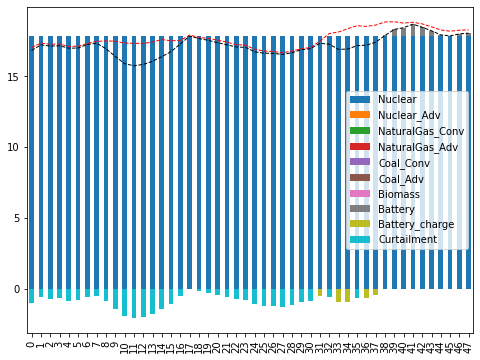

In [148]:
fig,ax = plt.subplots(facecolor='w', figsize=(8,6))
N = 48
d = 0
# model.results[['Nuclear', 'Battery', 'Battery_charge']].plot(ax=ax,kind='bar', stacked=True)
ax.plot(range(N), net_dem[d*N:(d+1)*N], color='k', lw=1, linestyle='--')
ax.plot(range(N), ddf[d*N:(d+1)*N], color='r', lw=1, linestyle='--')
model.results[cols][d*N:(d+1)*N].plot(ax=ax,kind='bar', stacked=True)

In [143]:
model.results[cols].sum(axis=0)

Nuclear            101953.173434
Nuclear_Adv         81712.933886
NaturalGas_Conv         0.000000
NaturalGas_Adv         29.734784
Coal_Conv               0.000000
Coal_Adv                0.000000
Biomass                 0.000000
Battery               148.837173
Battery_charge       -148.837173
Curtailment             0.000000
dtype: float64

In [52]:
labels = cols[:-2] + ['SolarPanel','WindTurbine']

NameError: name 'cols' is not defined

In [50]:
import seaborn as sb

In [53]:
labels = get_tech_names(techs)

(0.0, 30.0)

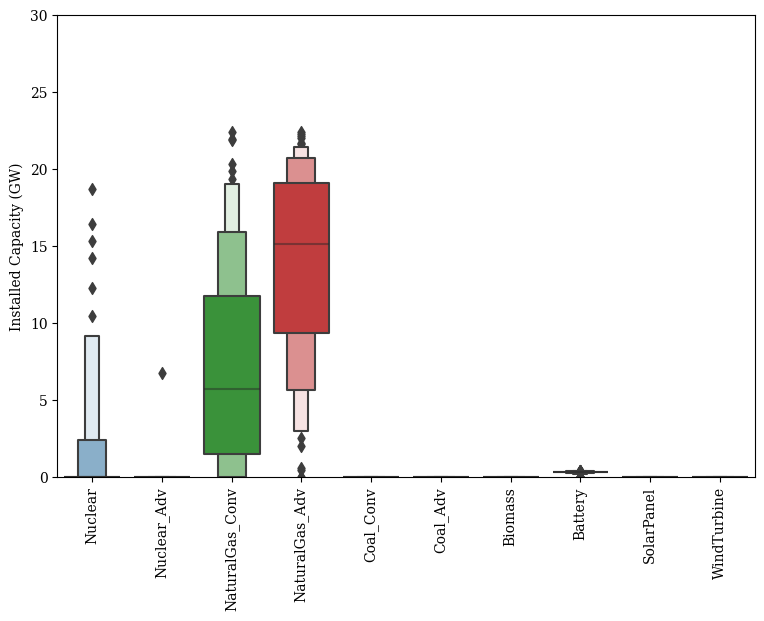

In [54]:
fig, ax = plt.subplots(figsize=(9,6), facecolor='w')
sb.boxenplot(ax=ax, data=(res.X)*problem.capacity_requirement)
ax.set_xticks(range(len(labels)))
ax.set_xticklabels(labels, rotation=90)
ax.set_ylabel('Installed Capacity (GW)')
ax.set_ylim(0, 30)

(0.0, 1.0)

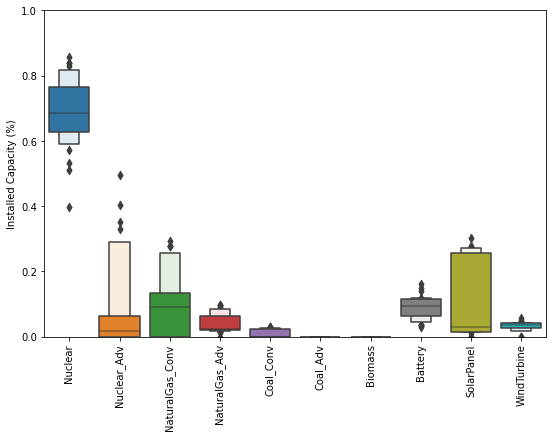

In [198]:
fig, ax = plt.subplots(figsize=(9,6), facecolor='w')
sb.boxenplot(ax=ax, data=(res.X))
ax.set_xticks(range(len(labels)))
ax.set_xticklabels(labels, rotation=90)
ax.set_ylabel('Installed Capacity (%)')
ax.set_ylim(0, 1)

(0.0, 1.0)

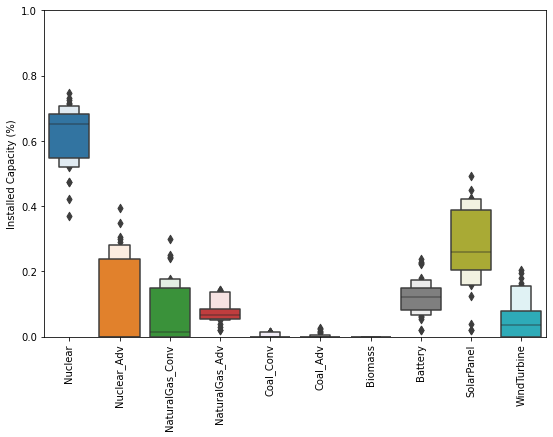

In [70]:
fig, ax = plt.subplots(figsize=(9,6), facecolor='w')
sb.boxenplot(ax=ax, data=(res.X))
ax.set_xticks(range(len(labels)))
ax.set_xticklabels(labels, rotation=90)
ax.set_ylabel('Installed Capacity (%)')
ax.set_ylim(0, 1)

In [236]:
osier = 32084.05615754519/25+4255.190232320458+1124.9568361387321
osier_min_cost = 3947.923027749778 + 5046.415689520423/25 + 1421.5244675189813
temoa = 12149.209202029999/25+3334.4663325999+1464.2538139680757

In [237]:
display(osier, osier_min_cost, temoa)

6663.509314760997

5571.304122849577

5284.688514649176

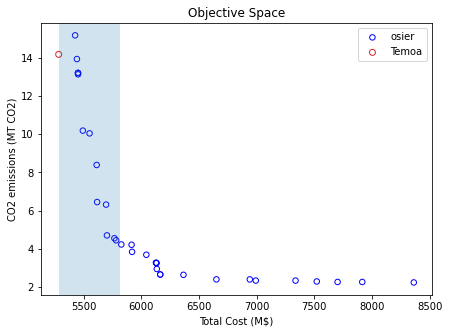

In [137]:
plt.figure(figsize=(7, 5), facecolor='w')
plt.scatter(F[:, 0], F[:, 1], s=30, facecolors='none', edgecolors='blue', label='osier')
# plt.scatter(F[11, 0], F[11, 1])
# plt.scatter(F[14, 0], F[14, 1], color='red')
plt.title("Objective Space")
temoa_min = 5284.688514649176
# temoa_min = 5513.633743
plt.scatter(x=temoa_min, y=14.171287287639815, 
            facecolors='none', edgecolors='tab:red', label='Temoa')
# plt.axvline(x=cost_min, alpha=0.2, linestyle='--')
# plt.axvline(x=ub, alpha=0.2, linestyle='--')
# plt.fill_betweenx(x1=cost_min, x2=ub, y=[2700,2900], alpha=0.2)
# plt.ylabel("Resentment")
# plt.xlabel("Cost")
# plt.xlim(3e3, 4e3)
# plt.ylim(0,4)
# plt.yscale('log')
# plt.xscale('log')

plt.axvspan(xmin=temoa_min, xmax=temoa_min*1.1, alpha=0.2)
plt.xlabel("Total Cost (M$)")
plt.ylabel("CO2 emissions (MT CO2)")
plt.legend()
plt.show()

In [150]:
temoa_mga_cost = [6043.94148,6043.94148,5710.54128,6034.077768,5622.833954,5513.633743]

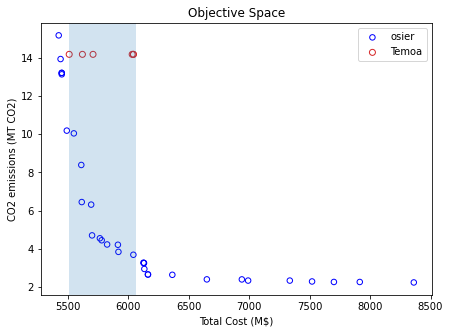

In [152]:
plt.figure(figsize=(7, 5), facecolor='w')
plt.scatter(F[:, 0], F[:, 1], s=30, facecolors='none', edgecolors='blue', label='osier')
# plt.scatter(F[11, 0], F[11, 1])
# plt.scatter(F[14, 0], F[14, 1], color='red')
plt.title("Objective Space")
temoa_min = np.min(temoa_mga_cost)
# temoa_min = 5513.633743
plt.scatter(x=temoa_mga_cost, y=np.ones(6)*14.171287287639815, 
            facecolors='none', edgecolors='tab:red', label='Temoa')
# plt.axvline(x=cost_min, alpha=0.2, linestyle='--')
# plt.axvline(x=ub, alpha=0.2, linestyle='--')
# plt.fill_betweenx(x1=cost_min, x2=ub, y=[2700,2900], alpha=0.2)
# plt.ylabel("Resentment")
# plt.xlabel("Cost")
# plt.xlim(3e3, 4e3)
# plt.ylim(0,4)
# plt.yscale('log')
# plt.xscale('log')

plt.axvspan(xmin=temoa_min, xmax=temoa_min*1.1, alpha=0.2)
plt.xlabel("Total Cost (M$)")
plt.ylabel("CO2 emissions (MT CO2)")
plt.legend()
plt.show()

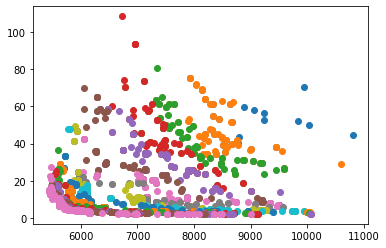

In [197]:
for h in res.history:
    F_hist = h.pop.get("F")
    mask = F_hist < 1e40
    F_hist = np.ma.masked_values(F_hist, 1e40)
    plt.scatter(F_hist[:,0], F_hist[:,1])

In [161]:
res.exec_time

41743.351348400116

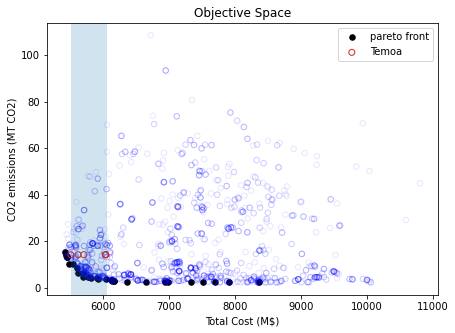

In [196]:
plt.figure(figsize=(7, 5), facecolor='w')
plt.scatter(F[:, 0], F[:, 1], s=30, facecolors='k', edgecolors='k', label='pareto front')

for h in res.history:
    F_hist = h.pop.get("F")
    F_hist = np.ma.masked_values(F_hist, 1e40)
    plt.scatter(F_hist[:, 0], F_hist[:, 1], s=30, facecolors='none', 
                edgecolors='blue', alpha=0.1)
# plt.scatter(F[11, 0], F[11, 1])
# plt.scatter(F[14, 0], F[14, 1], color='red')
plt.title("Objective Space")
temoa_min = np.min(temoa_mga_cost)
# temoa_min = 5513.633743
plt.scatter(x=temoa_mga_cost, y=np.ones(6)*14.171287287639815, 
            facecolors='none', edgecolors='tab:red', label='Temoa')
# plt.axvline(x=cost_min, alpha=0.2, linestyle='--')
# plt.axvline(x=ub, alpha=0.2, linestyle='--')
# plt.fill_betweenx(x1=cost_min, x2=ub, y=[2700,2900], alpha=0.2)
# plt.ylabel("Resentment")
# plt.xlabel("Cost")
# plt.xlim(3e3, 4e3)
# plt.ylim(0,4)
# plt.yscale('log')
# plt.xscale('log')

plt.axvspan(xmin=temoa_min, xmax=temoa_min*1.1, alpha=0.2)
plt.xlabel("Total Cost (M$)")
plt.ylabel("CO2 emissions (MT CO2)")
plt.legend()
plt.show()

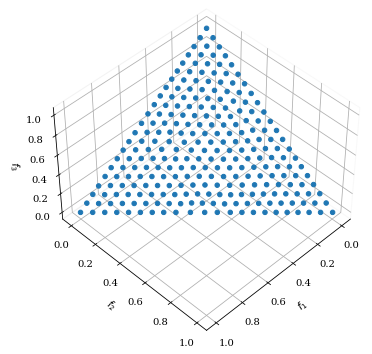

In [204]:
from pymoo.util.ref_dirs import get_reference_directions
from pymoo.visualization.scatter import Scatter

ref_dirs = get_reference_directions("energy", 3,  250, seed=1)

Scatter().add(ref_dirs).show()

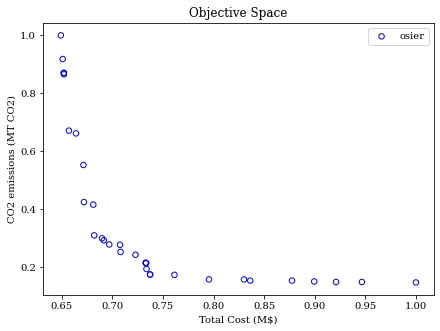

In [208]:
F2 = deepcopy(F)
F2[:,1] = F2[:,1] / F[:,1].max()
F2[:,0] = F2[:,0] / F[:,0].max()

plt.figure(figsize=(7, 5), facecolor='w')
plt.scatter(F2[:, 0], F2[:, 1], s=30, facecolors='none', edgecolors='blue', label='osier')
plt.title("Objective Space")
plt.xlabel("Total Cost (M$)")
plt.ylabel("CO2 emissions (MT CO2)")
plt.legend()
plt.show()

In [209]:
F.min(axis=0)

array([5.42696103e+03, 2.24524905e+00])

In [210]:
fl = F.min(axis=0)
fu = F.max(axis=0)
print(f"Scale f1: [{fl[0]}, {fu[0]}]")
print(f"Scale f2: [{fl[1]}, {fu[1]}]")

Scale f1: [5426.961033571195, 8361.396994956322]
Scale f2: [2.2452490515222094, 15.164265976040866]


In [317]:
np.random.seed(1)
B = np.array([1,1,1,1,1,0.5,0.2,0.3])
N = len(B)
N_gen = 10
B = B.reshape(1, N)
A = np.random.rand(N_gen,N)
# print(A)
A = A/A.sum(axis=1, keepdims=True)
# print(A.sum(axis=1))
A[A < 1e-2] = 0
A = A/A.sum(axis=1, keepdims=True)
display(A)
display(A/B)
display((A/B).sum(axis=1, keepdims=True))
display(A[:,-3:])
display(B[:,-3:])
display((A[:,-3:]/B[:,-3:]).sum(axis=1))
display((A[:,:-3]).sum(axis=1))
# A = A/A.sum()
# print(A)
# A2 = A*B
# print(A2.sum())
# print(((A/B)/(A/B).sum()).sum())
# print(((A/B)/(A/B).sum()))
# A4 = A3/A3.sum()
# display(np.dot(A2, B), (A4-A3)/A4)

array([[0.18864699, 0.32585103, 0.        , 0.13676528, 0.06638752,
        0.04177093, 0.08425797, 0.15632027],
       [0.10460421, 0.14205423, 0.1105169 , 0.18065202, 0.05390201,
        0.23150784, 0.        , 0.17676279],
       [0.10204958, 0.1366245 , 0.03433085, 0.04844462, 0.19581765,
        0.236783  , 0.07664615, 0.16930366],
       [0.25310716, 0.2583685 , 0.02456135, 0.01127929, 0.04904818,
        0.25361354, 0.02840324, 0.12161875],
       [0.20082727, 0.11178129, 0.14505617, 0.06614974, 0.14392902,
        0.17498426, 0.        , 0.15727224],
       [0.21685173, 0.16406856, 0.06149981, 0.17308456, 0.02263689,
        0.09822056, 0.19924994, 0.06438795],
       [0.13582317, 0.06137042, 0.        , 0.32039436, 0.09988348,
        0.12533176, 0.23201094, 0.02518586],
       [0.15794679, 0.04036683, 0.16212517, 0.1925121 , 0.02815346,
        0.11391188, 0.19103799, 0.11394579],
       [0.01151914, 0.12357638, 0.1530694 , 0.11873215, 0.21782121,
        0.13525814, 0.208322

array([[0.18864699, 0.32585103, 0.        , 0.13676528, 0.06638752,
        0.08354187, 0.42128987, 0.52106756],
       [0.10460421, 0.14205423, 0.1105169 , 0.18065202, 0.05390201,
        0.46301568, 0.        , 0.58920929],
       [0.10204958, 0.1366245 , 0.03433085, 0.04844462, 0.19581765,
        0.473566  , 0.38323073, 0.56434553],
       [0.25310716, 0.2583685 , 0.02456135, 0.01127929, 0.04904818,
        0.50722708, 0.14201618, 0.40539584],
       [0.20082727, 0.11178129, 0.14505617, 0.06614974, 0.14392902,
        0.34996853, 0.        , 0.5242408 ],
       [0.21685173, 0.16406856, 0.06149981, 0.17308456, 0.02263689,
        0.19644112, 0.99624969, 0.2146265 ],
       [0.13582317, 0.06137042, 0.        , 0.32039436, 0.09988348,
        0.25066352, 1.1600547 , 0.08395288],
       [0.15794679, 0.04036683, 0.16212517, 0.1925121 , 0.02815346,
        0.22782375, 0.95518996, 0.3798193 ],
       [0.01151914, 0.12357638, 0.1530694 , 0.11873215, 0.21782121,
        0.27051628, 1.041611

array([[1.74355012],
       [1.64395434],
       [1.93840946],
       [1.65100357],
       [1.54195283],
       [2.04545885],
       [2.11214253],
       [2.14393735],
       [2.04251687],
       [2.18377903]])

array([[0.04177093, 0.08425797, 0.15632027],
       [0.23150784, 0.        , 0.17676279],
       [0.236783  , 0.07664615, 0.16930366],
       [0.25361354, 0.02840324, 0.12161875],
       [0.17498426, 0.        , 0.15727224],
       [0.09822056, 0.19924994, 0.06438795],
       [0.12533176, 0.23201094, 0.02518586],
       [0.11391188, 0.19103799, 0.11394579],
       [0.13525814, 0.20832224, 0.03170133],
       [0.08160102, 0.17617323, 0.17035075]])

array([[0.5, 0.2, 0.3]])

array([1.0258993 , 1.05222497, 1.42114226, 1.05463909, 0.87420933,
       1.4073173 , 1.49467109, 1.56283301, 1.41779858, 1.61190403])

array([0.71765082, 0.59172937, 0.51726719, 0.59636448, 0.6677435 ,
       0.63814156, 0.61747144, 0.58110434, 0.62471829, 0.571875  ])

In [316]:
a = A

In [333]:
B = np.array([1,1,1,1,1,0.5,0.2,0.3])
a[a<1e-2] = 0
a = a/a.sum(axis=1, keepdims=True)
I = np.eye(N,N) * B
display(a[:,-3:],(I@a.T).T[:,-3:])#.sum(axis=0, keepdims=True).T)
a = ((a.T)/(I@a.T).sum(axis=0, keepdims=True)).T
# display(a, A)

array([[0.04177093, 0.08425797, 0.15632027],
       [0.23150784, 0.        , 0.17676279],
       [0.236783  , 0.07664615, 0.16930366],
       [0.25361354, 0.02840324, 0.12161875],
       [0.17498426, 0.        , 0.15727224],
       [0.09822056, 0.19924994, 0.06438795],
       [0.12533176, 0.23201094, 0.02518586],
       [0.11391188, 0.19103799, 0.11394579],
       [0.13525814, 0.20832224, 0.03170133],
       [0.08160102, 0.17617323, 0.17035075]])

array([[0.02088547, 0.01685159, 0.04689608],
       [0.11575392, 0.        , 0.05302884],
       [0.1183915 , 0.01532923, 0.0507911 ],
       [0.12680677, 0.00568065, 0.03648563],
       [0.08749213, 0.        , 0.04718167],
       [0.04911028, 0.03984999, 0.01931638],
       [0.06266588, 0.04640219, 0.00755576],
       [0.05695594, 0.0382076 , 0.03418374],
       [0.06762907, 0.04166445, 0.0095104 ],
       [0.04080051, 0.03523465, 0.05110523]])

In [330]:
0.15632027*0.3

0.046896081

In [326]:
b = np.ma.masked_greater_equal(B, 1)
b

masked_array(data=[--, --, --, --, --, 0.5, 0.2, 0.3],
             mask=[ True,  True,  True,  True,  True, False, False, False],
       fill_value=1e+20)